In [3]:
# Import Libraries
from pyspark.sql.types import StructType, StructField, FloatType, BooleanType
from pyspark.sql.types import DoubleType, IntegerType, StringType, TimestampType, LongType
from pyspark.sql.window import Window
from pyspark.sql import functions
from hops import kafka
from hops import tls
from hops import hdfs

# Setup Topic name
TOPIC_NAME = "kringlan-topic-1"

# Parquet file to read
PARQ_PATH  = "/Projects/" + hdfs.project_name() + "/Jupyter/eventhub-stream.parquet"

# Read in the Parquet file. Parquet files are self-describing so the schema is preserved.
# The result of loading a parquet file is also a DataFrame.
parquetFile = spark.read.parquet(PARQ_PATH)

In [4]:
parquetFile.head(5)

[Row(data=Row(observation=Row(value='-2.3', quantityKind='Temperature', sensorId='d5447b7e-5f19-45d1-b101-e38329134572', observationTime='2021-12-02T15:33:52Z'), sensor='https://proptechos.com/api/sensor/d5447b7e-5f19-45d1-b101-e38329134572')), Row(data=Row(observation=Row(value='1.0', quantityKind='State', sensorId='4d865d66-6638-48ed-9c1b-be937b1003ff', observationTime='2021-12-02T15:33:23Z'), sensor='https://proptechos.com/api/sensor/4d865d66-6638-48ed-9c1b-be937b1003ff')), Row(data=Row(observation=Row(value='20.0', quantityKind='Temperature', sensorId='04cc6b00-ef3b-4841-bff8-052402987225', observationTime='2021-12-02T15:33:24Z'), sensor='https://proptechos.com/api/sensor/04cc6b00-ef3b-4841-bff8-052402987225')), Row(data=Row(observation=Row(value='14.9', quantityKind='Temperature', sensorId='393e0a4f-e166-4090-b887-7243a035dc7f', observationTime='2021-12-02T15:33:50Z'), sensor='https://proptechos.com/api/sensor/393e0a4f-e166-4090-b887-7243a035dc7f')), Row(data=Row(observation=Row(v

In [5]:
parquetFile.tail(5)

[Row(data=Row(observation=Row(value='179.6', quantityKind='Pressure', sensorId='77ebf325-6787-42c5-b2be-c3c6111132d3', observationTime='2021-12-02T15:28:27Z'), sensor='https://proptechos.com/api/sensor/77ebf325-6787-42c5-b2be-c3c6111132d3')), Row(data=Row(observation=Row(value='18.0', quantityKind='Temperature', sensorId='231d441b-67ee-4154-8c7b-4ff433cb0cf2', observationTime='2021-12-02T15:28:26Z'), sensor='https://proptechos.com/api/sensor/231d441b-67ee-4154-8c7b-4ff433cb0cf2')), Row(data=Row(observation=Row(value='105.4', quantityKind='Pressure', sensorId='d3f49852-3b5c-44cd-8659-60d4abe15841', observationTime='2021-12-02T15:28:27Z'), sensor='https://proptechos.com/api/sensor/d3f49852-3b5c-44cd-8659-60d4abe15841')), Row(data=Row(observation=Row(value='180.0', quantityKind='Pressure', sensorId='3c5d361e-6f7d-42c2-9a3e-51d205aafc1c', observationTime='2021-12-02T15:28:27Z'), sensor='https://proptechos.com/api/sensor/3c5d361e-6f7d-42c2-9a3e-51d205aafc1c')), Row(data=Row(observation=Row(

In [26]:
parquetFile.schema

StructType(List(StructField(data,StructType(List(StructField(observation,StructType(List(StructField(value,StringType,true),StructField(quantityKind,StringType,true),StructField(sensorId,StringType,true),StructField(observationTime,StringType,true))),true),StructField(sensor,StringType,true))),true)))

In [47]:
parquetFile.show()

df = parquetFile.select("data.observation.*").orderBy('observationTime')
df.show(5)


+--------------------+
|                data|
+--------------------+
|{{-2.3, Temperatu...|
|{{1.0, State, 4d8...|
|{{20.0, Temperatu...|
|{{14.9, Temperatu...|
|{{1701.0, Flow, 7...|
|{{-1.8, Temperatu...|
|{{125.0, Pressure...|
|{{0.0, State, 184...|
|{{1033.5, Flow, 7...|
|{{82.4, Pressure,...|
|{{180.0, Pressure...|
|{{240.0, Pressure...|
|{{100.0, State, 3...|
|{{29.0, State, a1...|
|{{120.0, Pressure...|
|{{-2.6, Temperatu...|
|{{22.6, Temperatu...|
|{{1.0, State, 2f5...|
|{{89.0, State, 3f...|
|{{23.1, Temperatu...|
+--------------------+
only showing top 20 rows

+-----+------------+--------------------+--------------------+
|value|quantityKind|            sensorId|     observationTime|
+-----+------------+--------------------+--------------------+
|239.9|    Pressure|c0254d73-dbe4-4c8...|2021-12-02T15:28:21Z|
|240.0|    Pressure|1a0f2e5c-8dc8-46d...|2021-12-02T15:28:21Z|
|125.7|    Pressure|27979a59-6c73-46e...|2021-12-02T15:28:22Z|
|  0.0|       State|61e62925-a655-4a9...|202

In [11]:
# Select and flatten the data
w = Window().orderBy(functions.lit('A'))
df = parquetFile.orderBy('data.observation.observationTime').withColumn("row", functions.row_number().over(w)).select("row", "data.observation.*").withColumnRenamed('quantityKind', 'kind').withColumnRenamed('observationTime', 'time').select('row','kind','value','sensorId','time')
df.show(100, truncate=False)

+---+-----------+------+------------------------------------+--------------------+
|row|kind       |value |sensorId                            |time                |
+---+-----------+------+------------------------------------+--------------------+
|1  |Pressure   |239.9 |c0254d73-dbe4-4c8e-a15f-2aae19c62a8a|2021-12-02T15:28:21Z|
|2  |Pressure   |240.0 |1a0f2e5c-8dc8-46db-ba4f-22b3e48adfc7|2021-12-02T15:28:21Z|
|3  |Pressure   |125.7 |27979a59-6c73-46e1-b565-7c14fbda5e2d|2021-12-02T15:28:22Z|
|4  |State      |0.0   |61e62925-a655-4a99-9f84-9e66f5ab1c85|2021-12-02T15:28:23Z|
|5  |State      |1.0   |2f5a505c-77ef-47c7-8f81-ae92cdf4328b|2021-12-02T15:28:23Z|
|6  |State      |1.0   |4d865d66-6638-48ed-9c1b-be937b1003ff|2021-12-02T15:28:23Z|
|7  |Pressure   |125.0 |3244f8e6-3dbc-40ac-b327-654dc0b5846d|2021-12-02T15:28:23Z|
|8  |State      |0.0   |8ecb4c6c-3a5e-4d76-9592-0d72fe2f04a1|2021-12-02T15:28:23Z|
|9  |State      |100.0 |3e2bc09b-531c-4fd3-9535-584e053891e6|2021-12-02T15:28:23Z|
|10 

In [48]:
from pyspark.sql.functions import to_timestamp, unix_timestamp
df_temp = df.where('quantityKind="Temperature" AND sensorId="0964daa6-282e-4bd7-a0f4-9beb6786e8a0"')
df_temp.show(truncate=False)
df_temp = df_temp.select('value', to_timestamp(df_temp.observationTime).alias('time'))
df_temp = df_temp.select(df_temp.value.cast('double').alias('value'),unix_timestamp(df_temp.time).alias('time'))

print(df_temp.schema)
df_temp.tail(5)

+-----+------------+------------------------------------+--------------------+
|value|quantityKind|sensorId                            |observationTime     |
+-----+------------+------------------------------------+--------------------+
|-2.5 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:28:26Z|
|-2.5 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:33:47Z|
|-2.6 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:38:27Z|
|-2.6 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:43:48Z|
|-2.6 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:48:27Z|
|-2.7 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:53:48Z|
|-2.8 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T15:58:27Z|
|-2.8 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T16:03:49Z|
|-2.8 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786e8a0|2021-12-02T16:08:28Z|
|-2.8 |Temperature |0964daa6-282e-4bd7-a0f4-9beb6786

In [49]:
%%spark -n -1 -o df_temp

This is intentionally empty


Text(0.5, 1.0, 'Sensor temperature data')

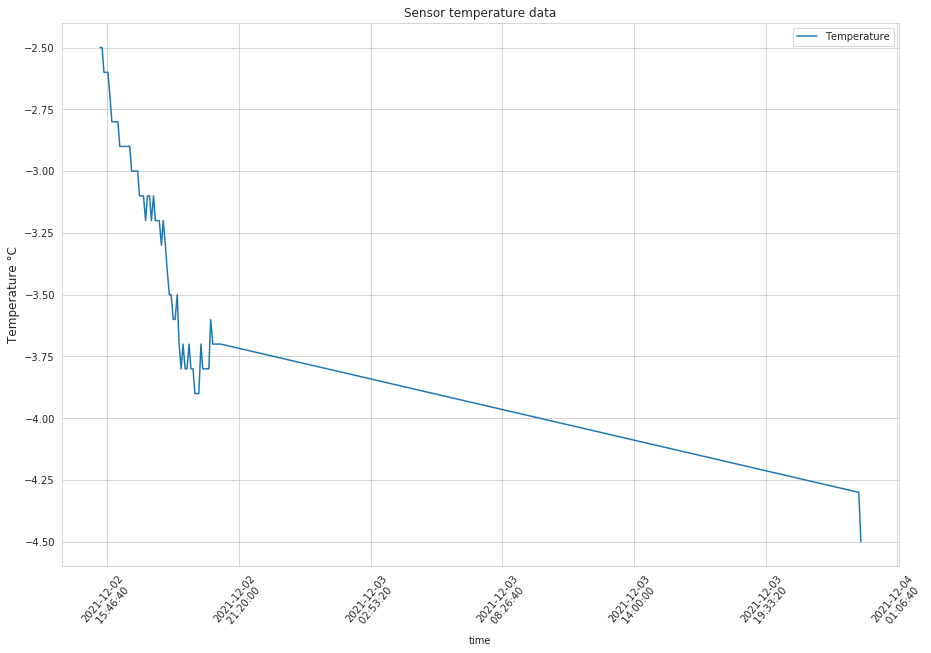

In [44]:
%%local
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize']=(15,10)
sns.set_style("whitegrid")

p = sns.lineplot("time", "value", data = df_temp)

#p.set_xlabel("Time", fontsize = 12)
p.set_ylabel("Temperature °C", fontsize = 12)

plt.legend(labels=['Temperature'])
xticks = p.get_xticks()
p.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks], rotation=50)

p.set_title("Sensor temperature data")